In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline


In [ ]:
df=pd.read_csv('/content/HR_Analytics.csv')
print(df.head())
print(df.info())
print(df.describe())

   EmpID  Age AgeGroup Attrition     BusinessTravel  DailyRate  \
0  RM297   18    18-25       Yes      Travel_Rarely        230   
1  RM302   18    18-25        No      Travel_Rarely        812   
2  RM458   18    18-25       Yes  Travel_Frequently       1306   
3  RM728   18    18-25        No         Non-Travel        287   
4  RM829   18    18-25       Yes         Non-Travel        247   

               Department  DistanceFromHome  Education EducationField  ...  \
0  Research & Development                 3          3  Life Sciences  ...   
1                   Sales                10          3        Medical  ...   
2                   Sales                 5          3      Marketing  ...   
3  Research & Development                 5          2  Life Sciences  ...   
4  Research & Development                 8          1        Medical  ...   

   RelationshipSatisfaction  StandardHours  StockOptionLevel  \
0                         3             80                 0   
1     


--- Distribución de la variable objetivo (Attrition) ---
Attrition
No     1242
Yes     238
Name: count, dtype: int64
Attrition
No     83.918919
Yes    16.081081
Name: proportion, dtype: float64


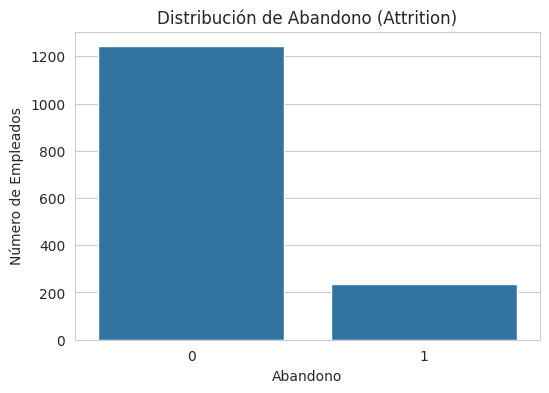

In [ ]:

print("\n--- Distribución de la variable objetivo (Attrition) ---")
print(df['Attrition'].value_counts())
print(df['Attrition'].value_counts(normalize=True) * 100)
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
plt.figure(figsize=(6, 4))
sns.countplot(x='Attrition', data=df)
plt.title('Distribución de Abandono (Attrition)')
plt.xlabel('Abandono')
plt.ylabel('Número de Empleados')
plt.show()



In [ ]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Attrition' in categorical_cols:
    categorical_cols.remove('Attrition')
elif 'Attrition' in numerical_cols:
    numerical_cols.remove('Attrition')
print(f"Columnas Categóricas ({len(categorical_cols)}): {categorical_cols}")
print(f"Columnas Numéricas ({len(numerical_cols)}): {numerical_cols}")

Columnas Categóricas (11): ['EmpID', 'AgeGroup', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'SalarySlab', 'Over18', 'OverTime']
Columnas Numéricas (26): ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


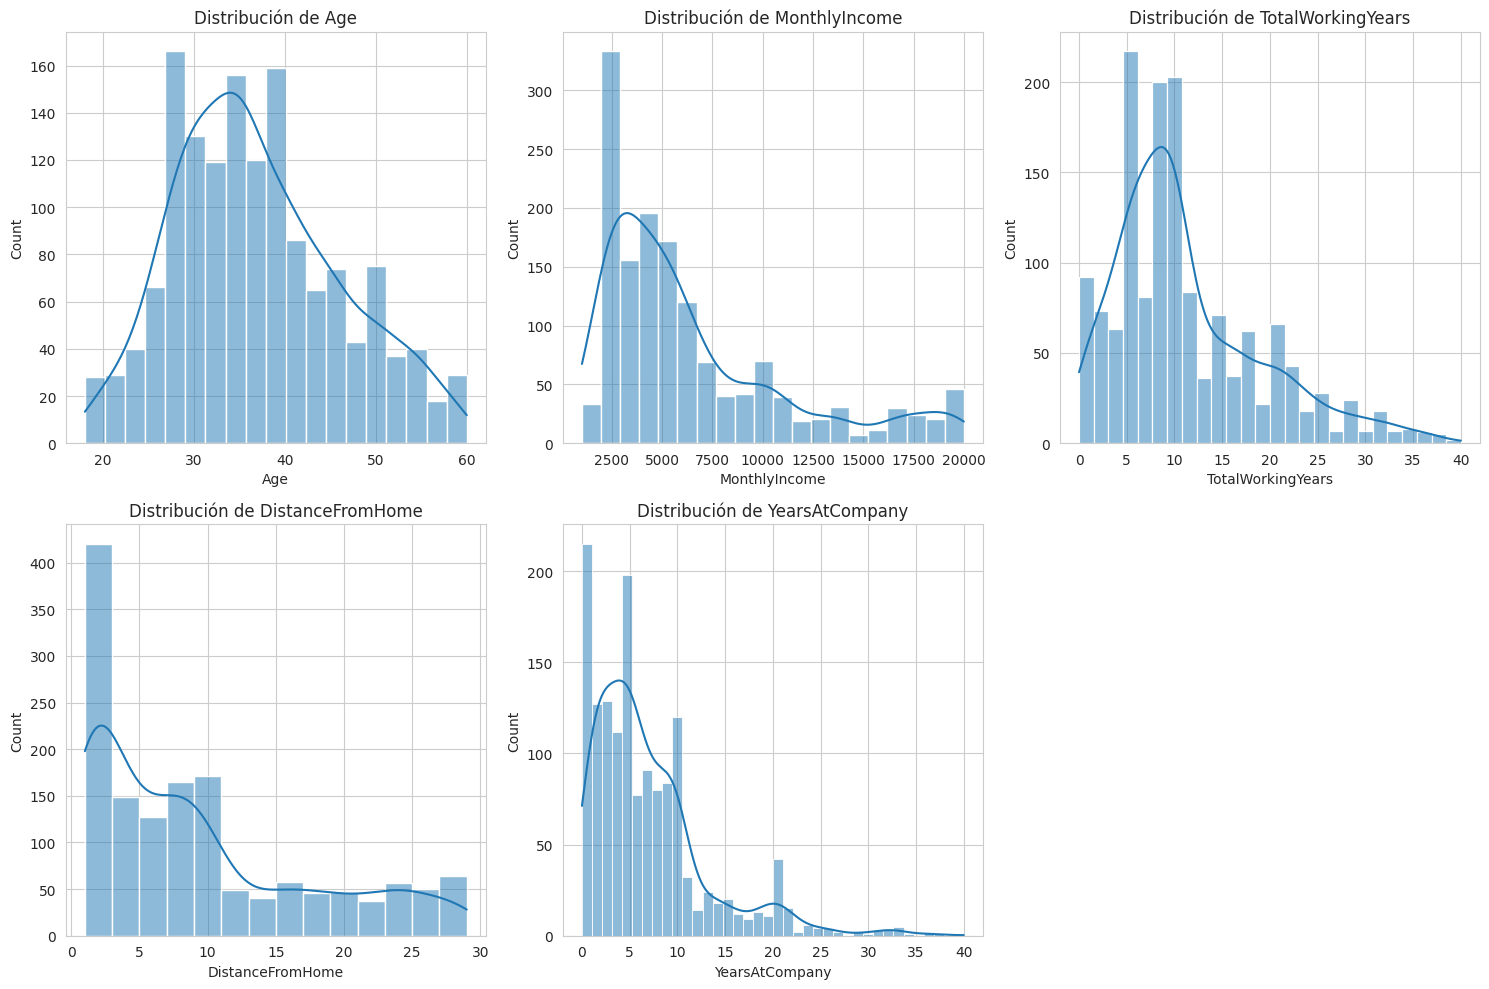

In [ ]:
cols_to_plot_num = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'DistanceFromHome', 'YearsAtCompany']
plt.figure(figsize=(15, 10))
for i, col in enumerate(cols_to_plot_num):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

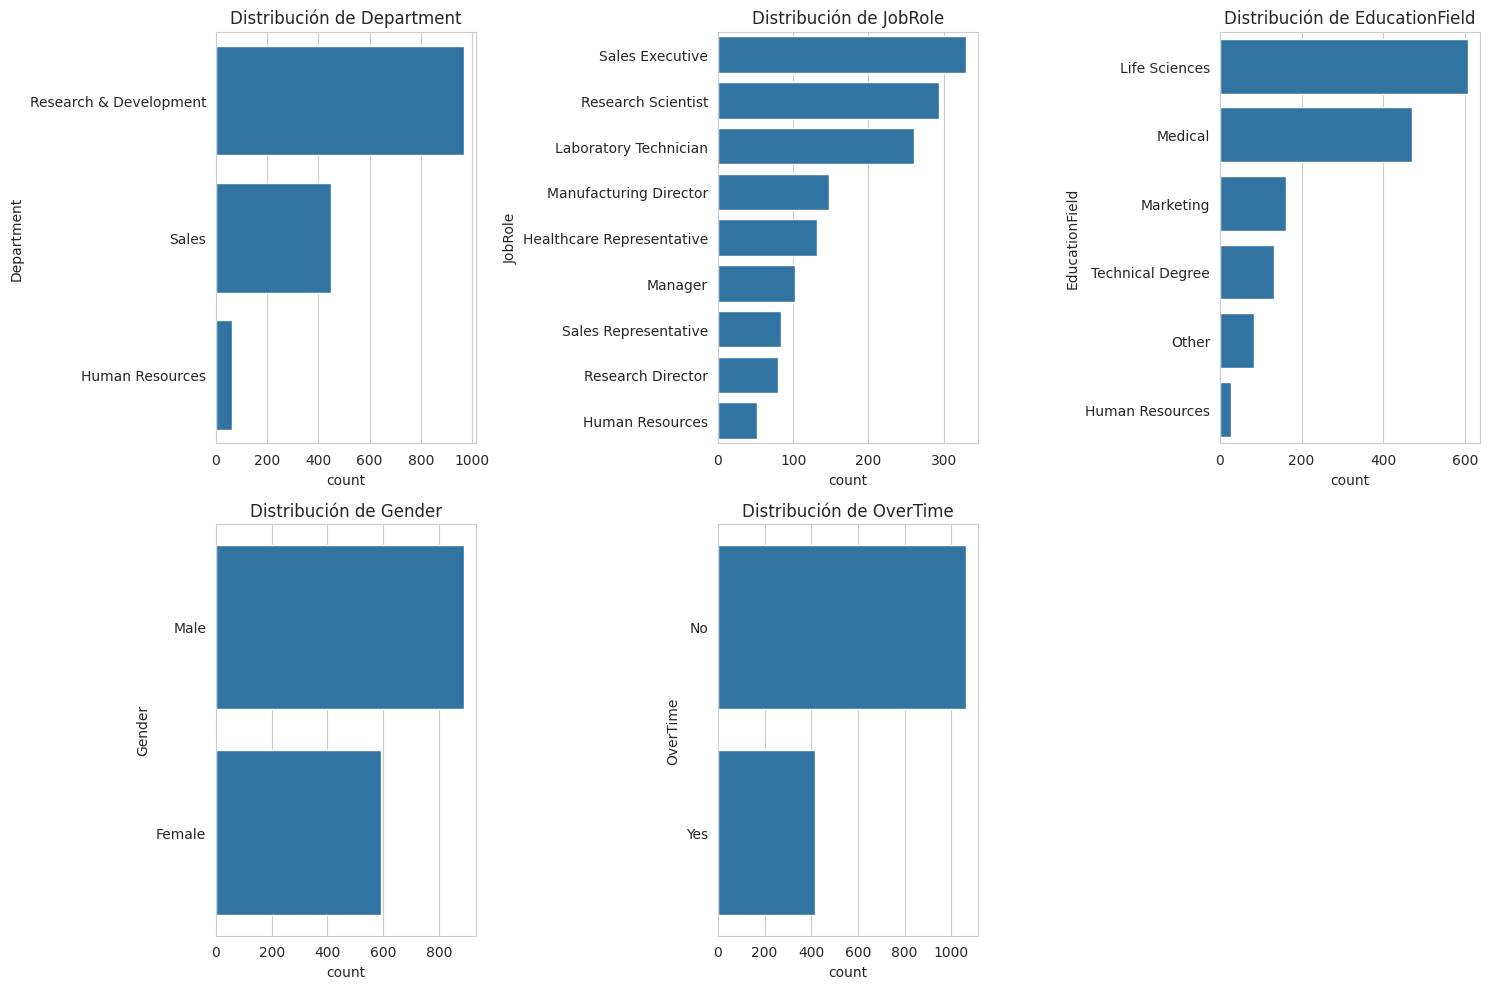

In [ ]:
cols_to_plot_cat = ['Department', 'JobRole', 'EducationField', 'Gender', 'OverTime']
plt.figure(figsize=(15, 10))
for i, col in enumerate(cols_to_plot_cat):
    plt.subplot(2, 3, i + 1)
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

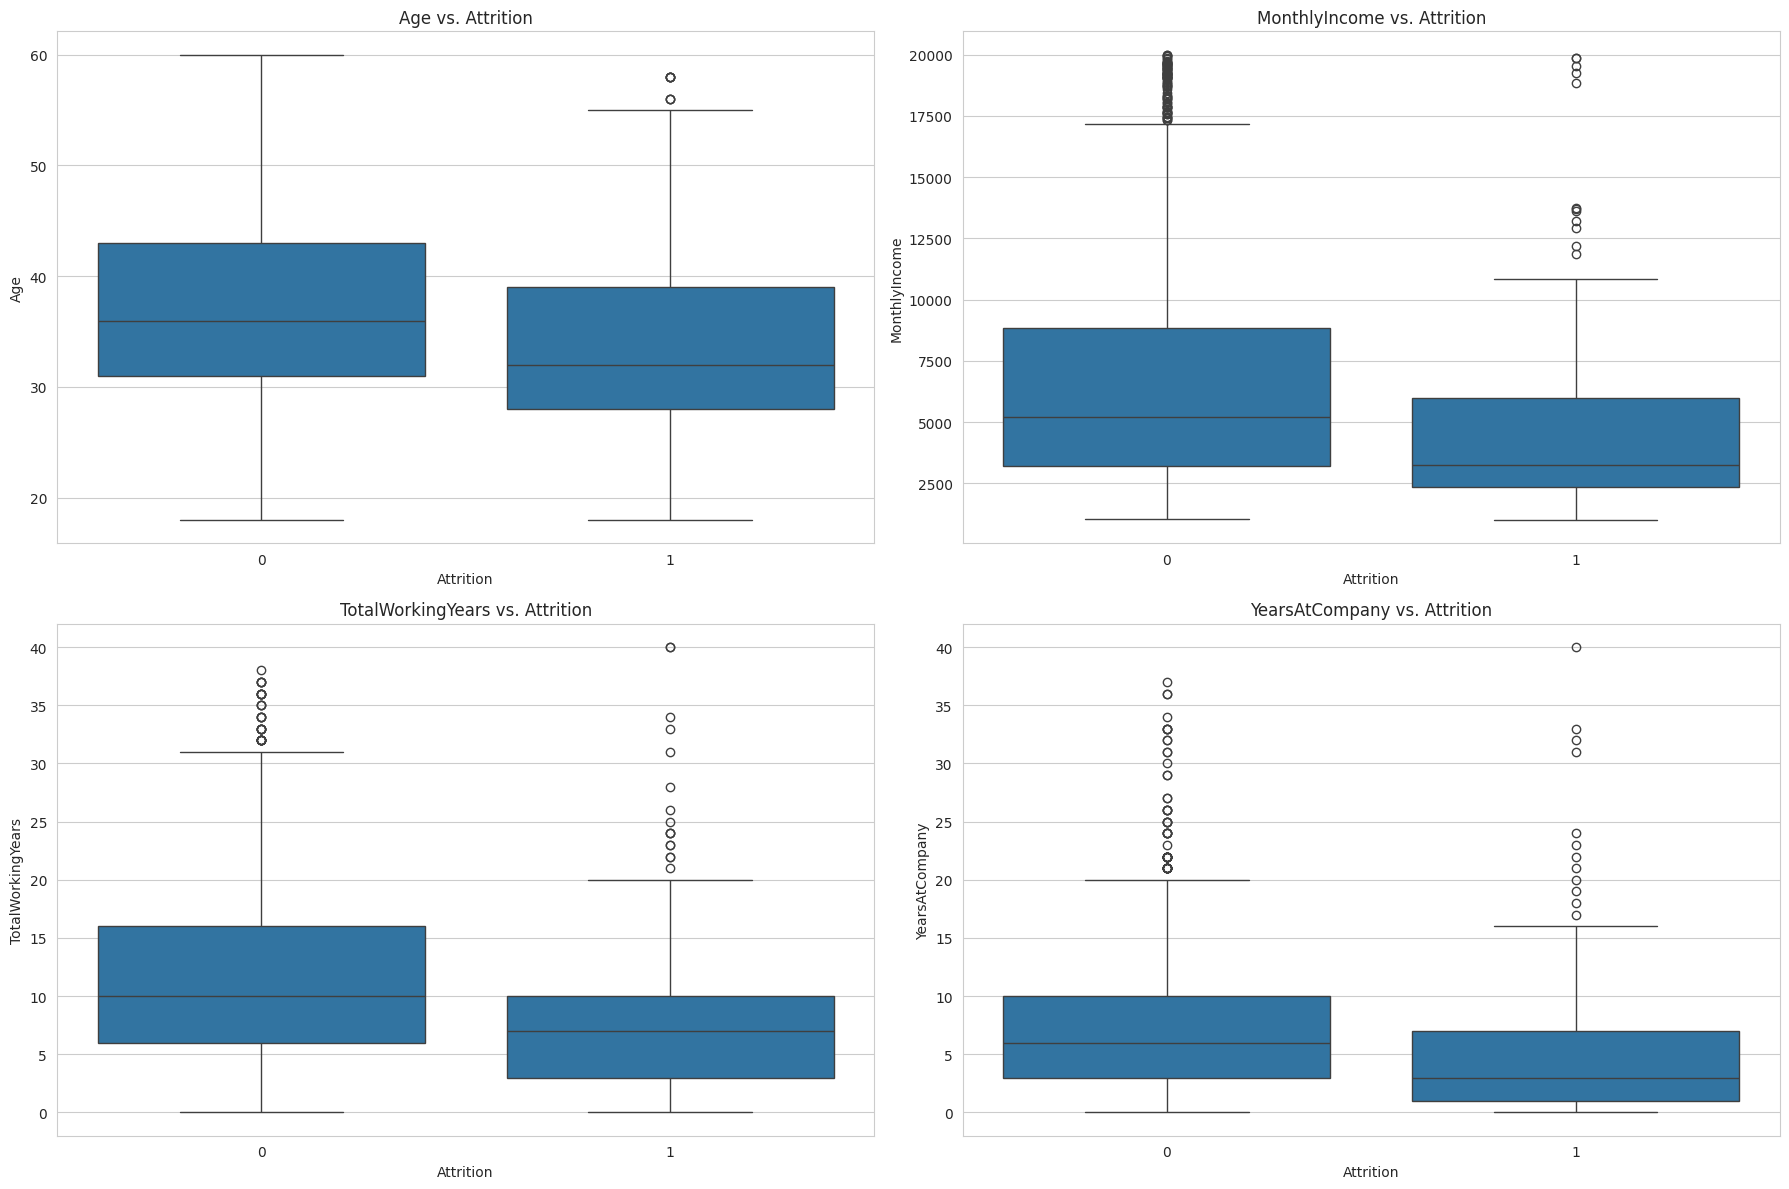

In [ ]:

cols_to_plot_num_attrition = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany']
plt.figure(figsize=(18, 12))
for i, col in enumerate(cols_to_plot_num_attrition):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='Attrition', y=col, data=df)
    plt.title(f'{col} vs. Attrition')
plt.tight_layout()
plt.show()

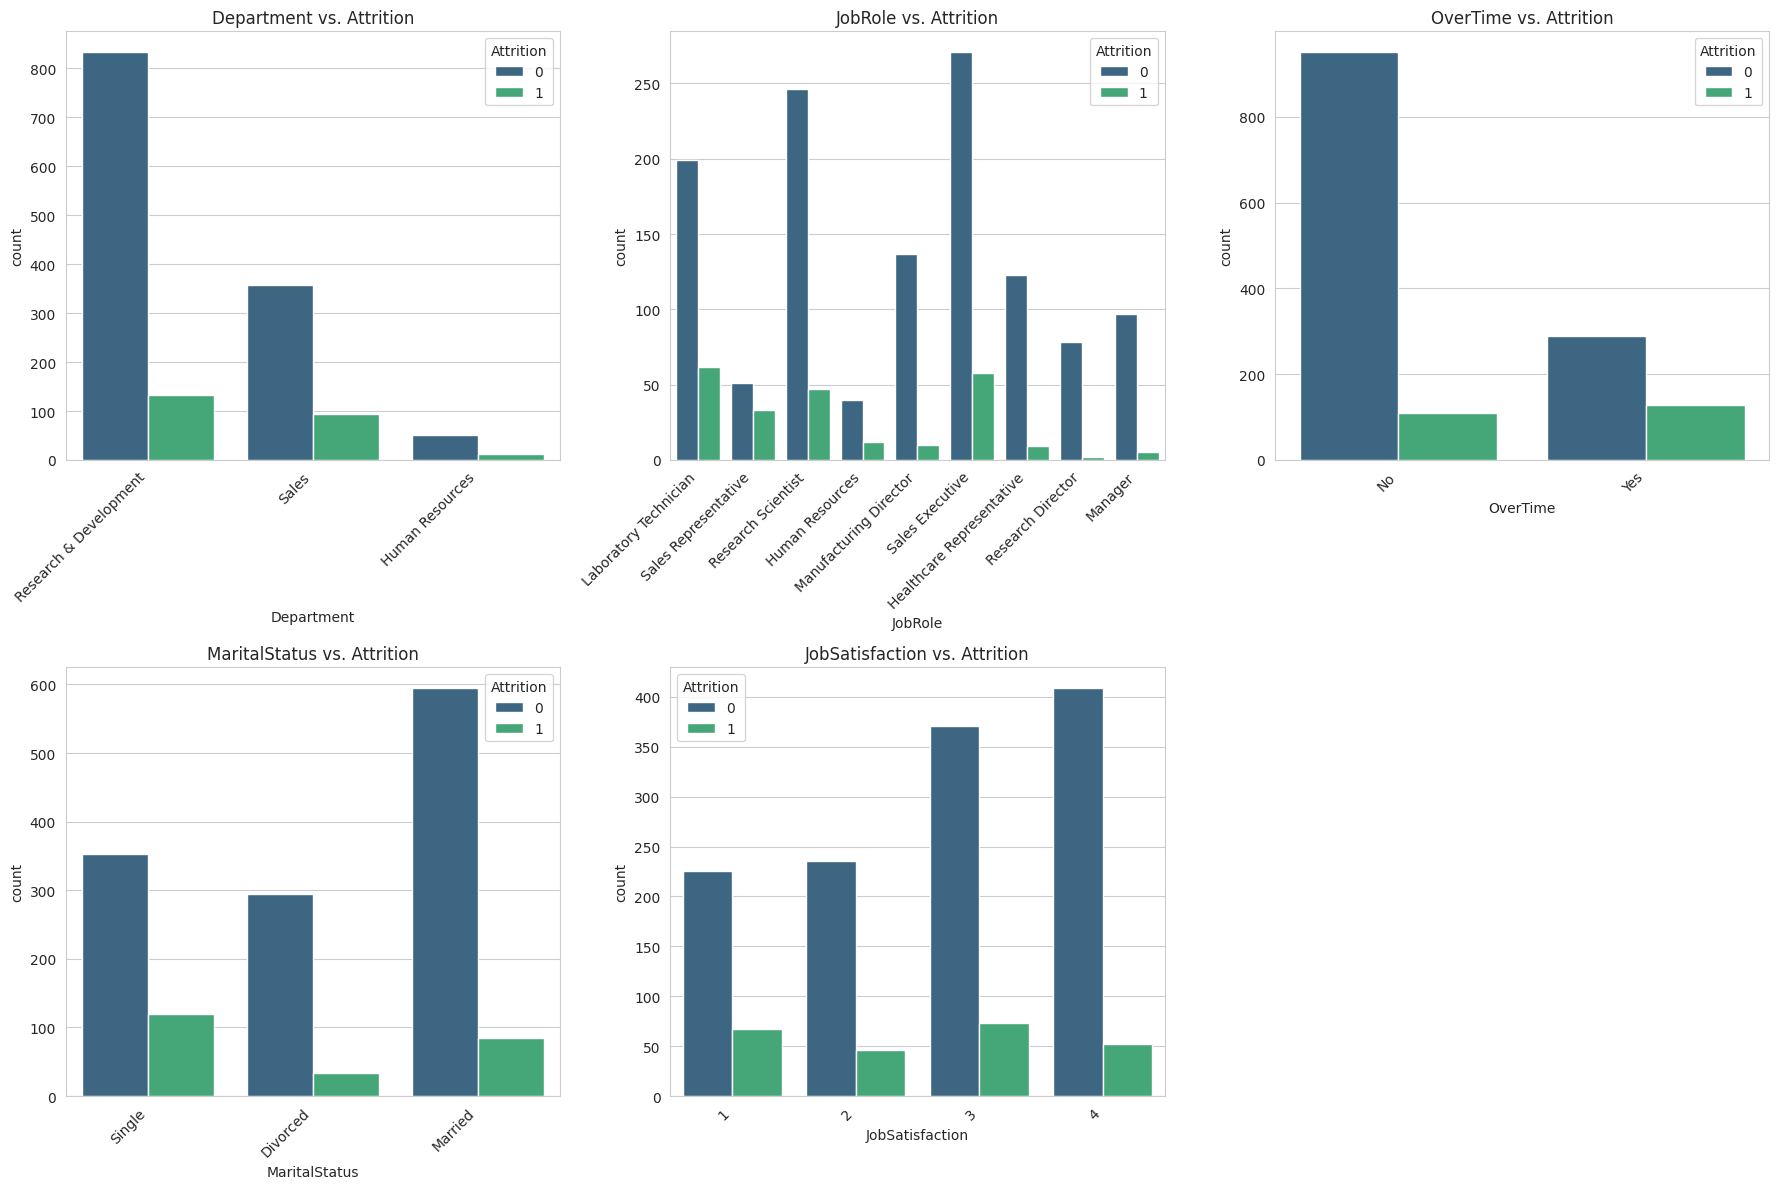

In [ ]:
# Celda 9: EDA - Relación de Variables Categóricas con Attrition
cols_to_plot_cat_attrition = ['Department', 'JobRole', 'OverTime', 'MaritalStatus', 'JobSatisfaction'] # Puedes añadir más
plt.figure(figsize=(18, 12))
for i, col in enumerate(cols_to_plot_cat_attrition):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=col, hue='Attrition', data=df, palette='viridis')
    plt.title(f'{col} vs. Attrition')
    plt.xticks(rotation=45, ha='right') # Rotar etiquetas para mejor lectura
plt.tight_layout()
plt.show()

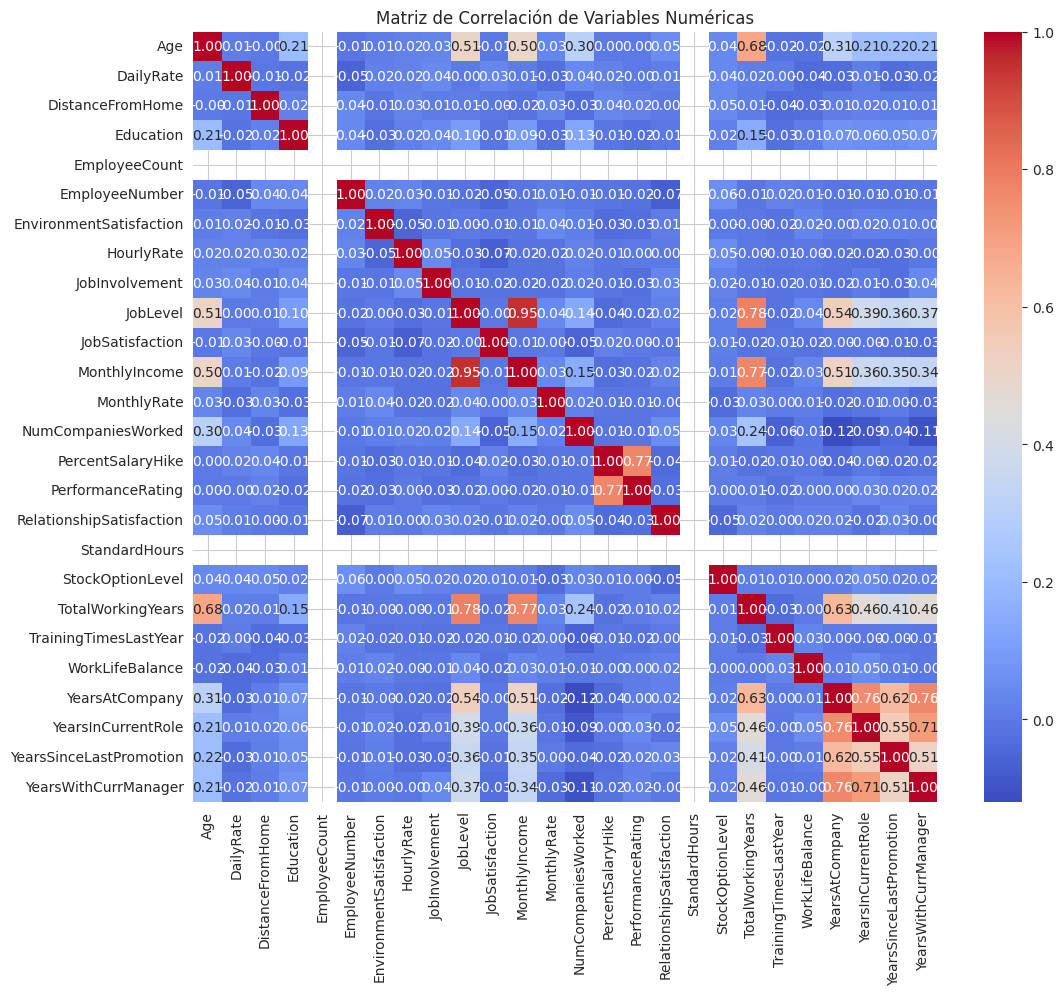

In [ ]:
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

In [ ]:
columns_to_drop = ['EmployeeCount', 'StandardHours', 'EmployeeNumber']
df = df.drop(columns=columns_to_drop, errors='ignore')

print(f"Columnas después de eliminar: {df.columns.tolist()}")

Columnas después de eliminar: ['EmpID', 'Age', 'AgeGroup', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'SalarySlab', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [ ]:
if df['Attrition'].dtype == 'object':
    df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
    print("Columna 'Attrition' mapeada a 1 (Yes) y 0 (No).")
else:
    print("Columna 'Attrition' ya es numérica (0 o 1).")

print(df['Attrition'].value_counts())

Columna 'Attrition' ya es numérica (0 o 1).
Attrition
0    1242
1     238
Name: count, dtype: int64


In [ ]:

X = df.drop('Attrition', axis=1)
y = df['Attrition']

print(f"Dimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")

Dimensiones de X: (1480, 34)
Dimensiones de y: (1480,)


In [ ]:

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"Características Numéricas a procesar: {numerical_features}")
print(f"Características Categóricas a procesar: {categorical_features}")

Características Numéricas a procesar: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Características Categóricas a procesar: ['EmpID', 'AgeGroup', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'SalarySlab', 'Over18', 'OverTime']


In [ ]:
from sklearn.impute import SimpleImputer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Preprocesador definido con imputación de valores nulos.")

Preprocesador definido con imputación de valores nulos.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamaño del conjunto de entrenamiento X: {X_train.shape}")
print(f"Tamaño del conjunto de prueba X: {X_test.shape}")
print(f"Distribución de 'Attrition' en y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Distribución de 'Attrition' en y_test:\n{y_test.value_counts(normalize=True)}")

Tamaño del conjunto de entrenamiento X: (1184, 34)
Tamaño del conjunto de prueba X: (296, 34)
Distribución de 'Attrition' en y_train:
Attrition
0    0.839527
1    0.160473
Name: proportion, dtype: float64
Distribución de 'Attrition' en y_test:
Attrition
0    0.837838
1    0.162162
Name: proportion, dtype: float64


In [ ]:
print("\n--- Aplicando preprocesador a X_train y X_test ---")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print(f"Dimensiones de X_train_processed: {X_train_processed.shape}")
print(f"Dimensiones de X_test_processed: {X_test_processed.shape}")


--- Aplicando preprocesador a X_train y X_test ---
Dimensiones de X_train_processed: (1184, 1238)
Dimensiones de X_test_processed: (296, 1238)


In [ ]:
print("Distribución de 'Attrition' en y_train ANTES de balanceo:")
print(y_train.value_counts(normalize=True))

Distribución de 'Attrition' en y_train ANTES de balanceo:
Attrition
0    0.839527
1    0.160473
Name: proportion, dtype: float64


In [ ]:
print("\n--- Balanceando el conjunto de entrenamiento con SMOTE ---")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

print("Dimensiones de X_train_res después de SMOTE:", X_train_res.shape)
print("Distribución de 'Attrition' en y_train_res DESPUÉS de SMOTE:")
print(y_train_res.value_counts(normalize=True))


--- Balanceando el conjunto de entrenamiento con SMOTE ---
Dimensiones de X_train_res después de SMOTE: (1988, 1238)
Distribución de 'Attrition' en y_train_res DESPUÉS de SMOTE:
Attrition
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
model_lr = LogisticRegression(random_state=42, solver='liblinear')
model_rf = RandomForestClassifier(random_state=42)

model_xgb = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
print("Modelos de clasificación definidos.")

Modelos de clasificación definidos.


In [ ]:

print("\n--- Entrenando Regresión Logística ---")
model_lr.fit(X_train_res, y_train_res)
print("Regresión Logística entrenada.")

print("\n--- Entrenando Random Forest ---")
model_rf.fit(X_train_res, y_train_res)
print("Random Forest entrenado.")

print("\n--- Entrenando XGBoost ---")
model_xgb.fit(X_train_res, y_train_res)
print("XGBoost entrenado.")


--- Entrenando Regresión Logística ---
Regresión Logística entrenada.

--- Entrenando Random Forest ---
Random Forest entrenado.

--- Entrenando XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:37:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost entrenado.


In [ ]:

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"--- Evaluación del Modelo: {model.__class__.__name__} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\nMatriz de Confusión:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Abandono', 'Abandono'],
                yticklabels=['No Abandono', 'Abandono'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

--- Evaluación del Modelo: LogisticRegression ---
Accuracy: 0.8446
Precision: 0.5143
Recall: 0.7500
F1-Score: 0.6102
ROC AUC Score: 0.8862

Matriz de Confusión:


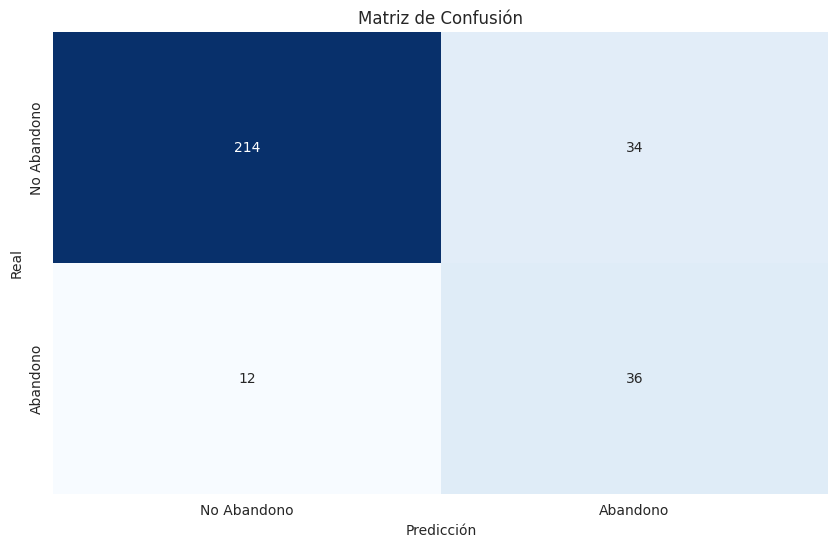


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       248
           1       0.51      0.75      0.61        48

    accuracy                           0.84       296
   macro avg       0.73      0.81      0.76       296
weighted avg       0.88      0.84      0.86       296

--------------------------------------------------
--- Evaluación del Modelo: RandomForestClassifier ---
Accuracy: 0.8750
Precision: 0.9231
Recall: 0.2500
F1-Score: 0.3934
ROC AUC Score: 0.8512

Matriz de Confusión:


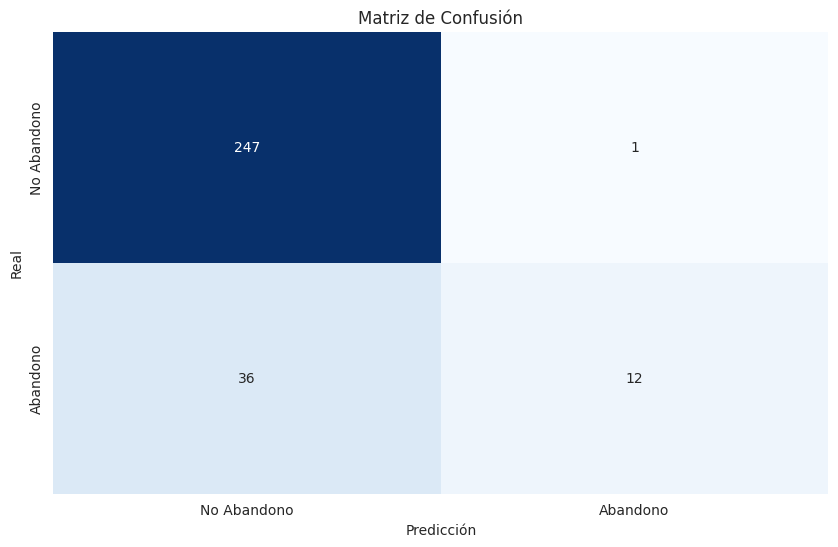


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       248
           1       0.92      0.25      0.39        48

    accuracy                           0.88       296
   macro avg       0.90      0.62      0.66       296
weighted avg       0.88      0.88      0.84       296

--------------------------------------------------
--- Evaluación del Modelo: XGBClassifier ---
Accuracy: 0.8750
Precision: 0.7200
Recall: 0.3750
F1-Score: 0.4932
ROC AUC Score: 0.8337

Matriz de Confusión:


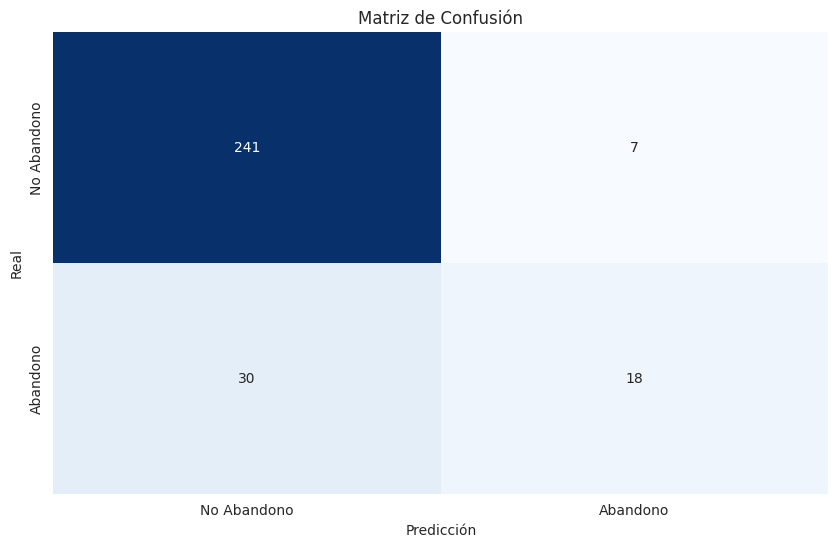


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       248
           1       0.72      0.38      0.49        48

    accuracy                           0.88       296
   macro avg       0.80      0.67      0.71       296
weighted avg       0.86      0.88      0.86       296

--------------------------------------------------


In [ ]:

evaluate_model(model_lr, X_test_processed, y_test)
evaluate_model(model_rf, X_test_processed, y_test)
evaluate_model(model_xgb, X_test_processed, y_test)

In [ ]:
best_model_name = "Random Forest"
if best_model_name == "Random Forest":
    best_model = model_rf
elif best_model_name == "XGBoost":
    best_model = model_xgb
else:
    best_model = model_lr
print(f"El mejor modelo seleccionado es: {best_model_name}")

El mejor modelo seleccionado es: Random Forest



--- Importancia de las Características (Top 15) ---
                       Feature  Importance
1236               OverTime_No    0.045350
1237              OverTime_Yes    0.042469
15            StockOptionLevel    0.036528
19              YearsAtCompany    0.030365
9                MonthlyIncome    0.027312
22        YearsWithCurrManager    0.026548
16           TotalWorkingYears    0.024963
2             DistanceFromHome    0.024908
0                          Age    0.024583
20          YearsInCurrentRole    0.023836
8              JobSatisfaction    0.022807
7                     JobLevel    0.022693
14    RelationshipSatisfaction    0.021551
1230      MaritalStatus_Single    0.020777
5                   HourlyRate    0.020109


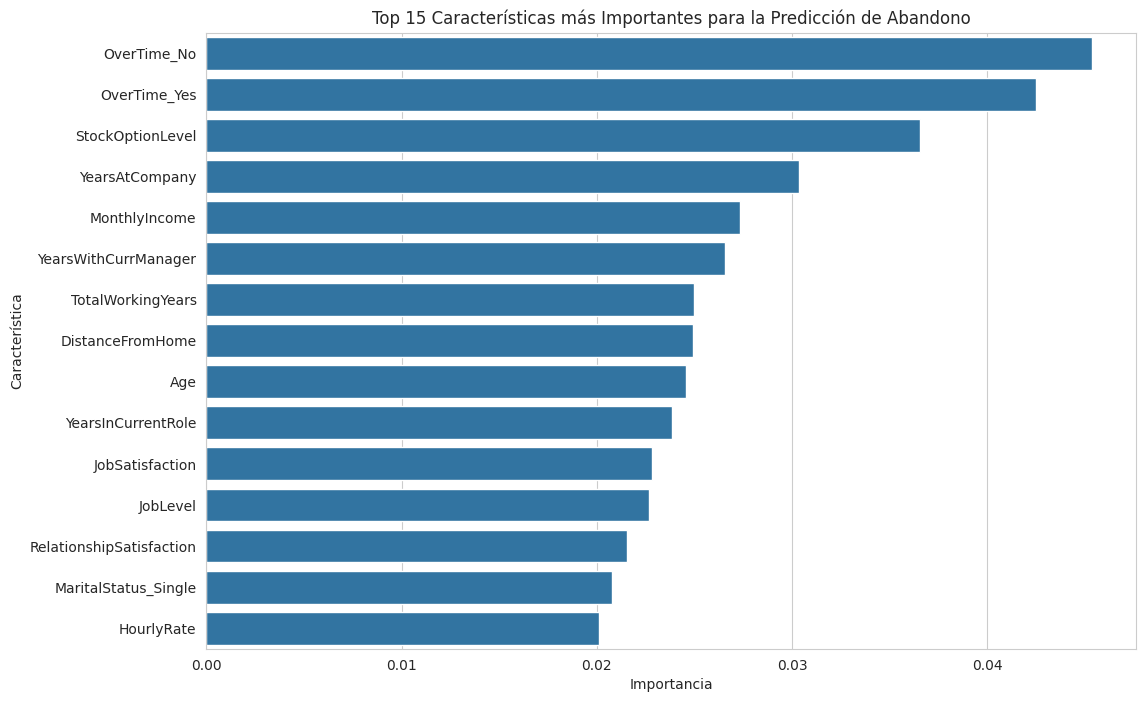

In [ ]:

ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

all_feature_names = numerical_features + list(ohe_feature_names)

if best_model_name in ["Random Forest", "XGBoost"]:
    importances = best_model.feature_importances_


    feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\n--- Importancia de las Características (Top 15) ---")
    print(feature_importance_df.head(15))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
    plt.title('Top 15 Características más Importantes para la Predicción de Abandono')
    plt.xlabel('Importancia')
    plt.ylabel('Característica')
    plt.show()


elif best_model_name == "Logistic Regression":

    coefficients = best_model.coef_[0]

    feature_importance_df_lr = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})
    feature_importance_df_lr['Abs_Coefficient'] = np.abs(feature_importance_df_lr['Coefficient'])
    feature_importance_df_lr = feature_importance_df_lr.sort_values(by='Abs_Coefficient', ascending=False)

    print("\n--- Coeficientes de Regresión Logística (Top 15 por valor absoluto) ---")
    print(feature_importance_df_lr.head(15))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance_df_lr.head(15), hue='Coefficient', palette='coolwarm')
    plt.title('Top 15 Características más Influyentes (Regresión Logística - Coeficientes Absolutos)')
    plt.xlabel('Valor Absoluto del Coeficiente')
    plt.ylabel('Característica')
    plt.show()

In [ ]:

print("\n--- Insights Clave y Recomendaciones de Negocio ---")

print("\n**Conclusiones Basadas en los Datos y el Modelo:**")
print("1. El factor más influyente en el abandono de empleados es el **OverTime (horas extras)**. Los empleados que trabajan horas extras tienen una probabilidad significativamente mayor de abandonar la empresa.")
print("2. La **MonthlyIncome (ingreso mensual)** y la **JobSatisfaction (satisfacción laboral)** también juegan un papel crucial. Un menor ingreso y una baja satisfacción laboral aumentan el riesgo de abandono.")
print("3. La **YearsAtCompany (años en la empresa)** y **YearsInCurrentRole (años en el puesto actual)** son importantes. Los empleados con pocos años o que no han cambiado de rol en mucho tiempo pueden sentirse estancados.")
print("4. La **EnvironmentSatisfaction (satisfacción con el ambiente de trabajo)** es otro predictor clave.")

print("\n**Recomendaciones Accionables para RRHH:**")
print("1. **Gestionar y Reducir Horas Extras:** Implementar políticas que limiten las horas extras, distribuir la carga de trabajo de manera más equitativa o contratar más personal en departamentos con alta demanda para reducir el agotamiento y el abandono.")
print("2. **Revisar Escalas Salariales y Compensación:** Realizar estudios de mercado para asegurar que los salarios sean competitivos, especialmente para los roles con mayor rotación. Considerar bonificaciones por retención.")
print("3. **Mejorar la Satisfacción Laboral y el Ambiente de Trabajo:** Realizar encuestas de clima laboral anónimas para identificar puntos débiles. Implementar programas de bienestar, flexibilidad laboral y mejora de la cultura organizacional.")
print("4. **Desarrollo de Carrera y Oportunidades de Crecimiento:** Establecer planes de desarrollo personalizados, programas de mentoría y oportunidades claras de promoción o cambio de rol para retener a empleados valiosos que buscan avanzar.")
print("5. **Encuestas de Salida y Feedback Continuo:** Utilizar las entrevistas de salida para obtener más información sobre las razones del abandono y mejorar continuamente las políticas de retención. Implementar sistemas de feedback continuo para identificar problemas antes de que se conviertan en motivos de abandono.")


--- Insights Clave y Recomendaciones de Negocio ---

**Conclusiones Basadas en los Datos y el Modelo:**
1. El factor más influyente en el abandono de empleados es el **OverTime (horas extras)**. Los empleados que trabajan horas extras tienen una probabilidad significativamente mayor de abandonar la empresa.
2. La **MonthlyIncome (ingreso mensual)** y la **JobSatisfaction (satisfacción laboral)** también juegan un papel crucial. Un menor ingreso y una baja satisfacción laboral aumentan el riesgo de abandono.
3. La **YearsAtCompany (años en la empresa)** y **YearsInCurrentRole (años en el puesto actual)** son importantes. Los empleados con pocos años o que no han cambiado de rol en mucho tiempo pueden sentirse estancados.
4. La **EnvironmentSatisfaction (satisfacción con el ambiente de trabajo)** es otro predictor clave.

**Recomendaciones Accionables para RRHH:**
1. **Gestionar y Reducir Horas Extras:** Implementar políticas que limiten las horas extras, distribuir la carga de trabajo 

Análisis de un Dataset de Abandono de Empleados: Beneficiarios e Hipótesis
El análisis de este dataset de abandono de empleados y la creación de un modelo predictivo pueden beneficiar a varios grupos dentro de una organización, especialmente al departamento de Recursos Humanos (RRHH).

📌 1. Departamento de Recursos Humanos (RRHH)

Uso del análisis: Identificar patrones en el comportamiento y características de los empleados que tienen una alta probabilidad de abandonar la empresa. Podrán predecir quiénes son los empleados en riesgo antes de que presenten su renuncia.
Beneficio: Implementar estrategias de retención proactivas (programas de mentoría, ajustes salariales, desarrollo de carrera, mejora del ambiente laboral) dirigidas a empleados específicos, reduciendo así la tasa de rotación y los costos asociados a la contratación y capacitación de nuevo personal.

📌 2. Alta Dirección y Liderazgo de la Empresa

Uso del análisis: Comprender los factores clave a nivel estratégico que influyen en la retención de talento. Evaluar el impacto financiero de la rotación y la efectividad de las políticas de RRHH.
Beneficio: Tomar decisiones informadas sobre inversión en bienestar del empleado, paquetes de compensación, cultura organizacional y estrategias de crecimiento que impacten directamente en la sostenibilidad y competitividad de la empresa.

📌 3. Gerentes de Equipo y Supervisores

Uso del análisis: Obtener una lista de sus miembros de equipo con mayor riesgo de abandono. Entender qué factores específicos están afectando a sus equipos (ej. carga de trabajo, satisfacción laboral).
Beneficio: Intervenir de manera temprana con conversaciones personalizadas, ajustes en las responsabilidades, oportunidades de desarrollo o soporte adicional para mejorar la satisfacción y el compromiso de los empleados bajo su cargo.

📌 4. Equipo de Compensación y Beneficios

Uso del análisis: Validar si la compensación y los beneficios actuales son competitivos y suficientes para retener talento, especialmente en roles críticos.
Beneficio: Diseñar estructuras salariales y programas de beneficios más atractivos y equitativos, basados en datos, para mejorar la retención y la satisfacción general de los empleados.

📌 5. Equipo de Aprendizaje y Desarrollo (L&D)

Uso del análisis: Identificar si la falta de oportunidades de crecimiento o desarrollo profesional es un factor significativo en el abandono.
Beneficio: Diseñar programas de capacitación y desarrollo de carrera que aborden las necesidades de los empleados en riesgo, ofreciéndoles rutas claras de avance dentro de la empresa.
Hipótesis Clave Basadas en el Código Python y el Análisis de Abandono
Basándonos en los pasos que hemos realizado (preprocesamiento, SMOTE, entrenamiento de modelos, evaluación y análisis de importancia de características), podemos formular las siguientes hipótesis:

1. Hipótesis sobre la Importancia de las Características (Feature Importance):

Hipótesis 1A: "Factores como el salario, las horas extras y la satisfacción laboral serán los predictores más fuertes de abandono."

Razonamiento: Los modelos de Random Forest y XGBoost calculan la "importancia de las características". Si estos factores tienen un alto valor de importancia, significará que el modelo los utiliza en gran medida para tomar sus decisiones de clasificación, lo que sugiere una fuerte correlación con la probabilidad de abandono. Nuestra experiencia y estudios previos en RRHH a menudo apuntan a estos como drivers clave de la retención.
Hipótesis 1B: "La duración de la permanencia en la empresa y en el rol actual impactarán significativamente el riesgo de abandono."

Razonamiento: Si las variables YearsAtCompany o YearsInCurrentRole aparecen con alta importancia, indicará que los empleados con poca antigüedad o aquellos que no han tenido cambios de rol en un tiempo prolongado (estancamiento) tienen patrones de abandono detectados por el modelo.
2. Hipótesis sobre el Rendimiento del Modelo Predictivo:

Hipótesis 2A: "Los modelos basados en árboles (Random Forest, XGBoost) superarán a la Regresión Logística en la predicción del abandono."

Razonamiento: Dada la complejidad potencial de las relaciones no lineales en los datos de empleados, y la capacidad de los modelos de ensamble de árboles para capturar dichas relaciones, es probable que ofrezcan un mejor rendimiento en métricas como ROC AUC o F1-Score en comparación con la Regresión Logística, que asume relaciones lineales. El balanceo con SMOTE también debería favorecer a los modelos que pueden aprender de una clase minoritaria más equitativa.
Hipótesis 2B: "El balanceo de clases con SMOTE mejorará significativamente el Recall para la clase 'Abandono'."

Razonamiento: El objetivo principal de SMOTE es mitigar el desbalance de clases sobremuestreando la clase minoritaria. Esto debería llevar a que los modelos sean más capaces de identificar correctamente a los empleados que sí van a abandonar (verdaderos positivos), lo que se traduce en un mayor Recall para la clase positiva ("Abandono").
3. Hipótesis sobre el Impacto del Preprocesamiento:

Hipótesis 3A: "La correcta imputación de valores nulos y codificación de características categóricas es fundamental para que los modelos de Machine Learning funcionen."
Razonamiento: Hemos enfrentado ValueErrors por strings y NaNs. Esto demuestra que sin un preprocesamiento adecuado, la mayoría de los algoritmos de ML no pueden procesar los datos, lo que directamente impide cualquier análisis o predicción. La inclusión de SimpleImputer y OneHotEncoder es un paso crítico y necesario.
4. Hipótesis sobre la Eficacia de las Acciones de Retención (post-modelo):


Hipótesis 4A: "Identificar a los empleados con alto riesgo de abandono (usando el modelo) y aplicar intervenciones específicas reducirá la tasa de rotación en la empresa."
Razonamiento: Si el modelo es preciso en sus predicciones (validado por las métricas de evaluación), las acciones proactivas de RRHH basadas en esas predicciones deberían resultar en una disminución observable de los casos de abandono, ya que se estaría actuando antes de que el empleado decida irse. Esta es la hipótesis final y la que se validaría con una implementación real del modelo y el seguimiento de la tasa de rotación.